In [82]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial, wraps
import time

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from InterObject import * 
from Global import * 

In [83]:
## Set up the API calls 
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }

## Read in all of the files to be used in the task
file_path1 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Setup_Functions.py'
with open(file_path1, 'r') as file:
    file_contents1 = file.read()

file_path2 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/InterObject.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()


def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for line in lines: 
        if line not in unique_lines:
            unique_lines.append(line)
    return("\n").join(unique_lines)

def check_and_call(func_name, *args, **kwargs):
    """
    Calls the function with the given name if it exists in the global namespace.
    Returns the function's result or 0 if the function does not exist.
    """
    if func_name in globals() and callable(globals()[func_name]):
        return globals()[func_name](*args, **kwargs)
    else:
        return 0

def check_calls_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return result
    return wrapper


# Set up the Room (all dimensions + fixed features)

### Set the Scene Descriptor

In [84]:
start_time = time.time() # Start the time
scene_descriptor = "a bedroom for a couple."

### Run the room set up calls (LangPrompt1, Prompt1)

In [85]:
lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets. For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": lang_prompt1}],
    max_tokens=500
)
objects = lang1output.choices[0].message.content.split("}, {")

prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents1 + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
No other text. Please ensure the correct number of inputs are given for each function."""

# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
        {"role": "user", "content": prompt1}
    ]
}

# Make the API call
response1 = requests.post(url, headers=headers, json=data)  
# Check the response
if response1.status_code == 200:
    response_data1 = response1.json()
    if "```python" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response_data1['choices'][0]['message']['content']:
        response1 = (response_data1['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else: 
        response1 = response_data1['choices'][0]['message']['content']
else:
    print('Failed to get a response')
    print(response1.text)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
## If the room is not defined properly, correct it
for line in response1: 
    if '=' not in line: 
        response1 = ['room = ' + line]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)

width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
(minimum is 1 region - for smaller rooms give fewer regions) should there be based on the description, as well as the size of the room (if the room is small, don't give too many regions). 
Some rooms may only need one region and that's okay. Return this as a simple bullet list of regions to include. Return these in list of priority order. 
Only return the list of regions. No other information please."""

lang2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=500
    )

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output.choices[0].message.content + """, using the function region_setup defined below, 
initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating', 0). No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: Room obj (this should be the name of the room)
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""
# Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt2}
            ]
    }
    
# Make the API call
response2 = requests.post(url, headers=headers, json=data)  
# Check the response
if response2.status_code == 200:
    response_data2 = response2.json()
    if "```python" in response_data2['choices'][0]['message']['content']:
        response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response2 = response_data2['choices'][0]['message']['content']
        
    global_context = globals().copy()
    local_context = {}  
    exec(response1 + "\n" + response2.replace("'" + room_name + "'", room_name), global_context, local_context)
else:
    print('Failed to get a response')
    print(response2.text)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

if "'" + room_name + "'" in response2:
    response2 = response2.replace("'" + room_name + "'", "local_context[room_name]")
elif '"' + room_name + '"' in response2:
    response2 = response2.replace('"' + room_name + '"', "local_context[room_name]")
else: 
    response2 = response2.replace(room_name, "local_context[room_name]")

region_setups = response2.split("\n")

In [86]:
print(response1)

room = create_room(4, 5)
create_fixed_object(room, 'window', 1.2, 0.1, 'north', position = 0.25)
create_fixed_object(room, 'window', 1.2, 0.1, 'north', position = 0.75)
create_fixed_object(room, 'door', 0.9, 0.1, 'south', position = 0.10)
create_fixed_object(room, 'socket', 0.1, 0.1, 'east', position = 0.3)
create_fixed_object(room, 'socket', 0.1, 0.1, 'east', position = 0.7)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', position = 0.4)


# Get the primary objects, as well as all of their constraints. 

In [87]:
lang_prompt3 = "The room is described as " + scene_descriptor + ". Now for each one of the regions: " + region_names + """, 
what is the most important object to include (keep in mind the room description), and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region (there can only be two of the same object if NECESSARY. If that is the case, output them as bed 1 and bed 2 or
chair 1 and chair 2). The size of the room is """ + width + "m x " + length + """m, bear this in mind when choosing the objects and the size 
of the objects. Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = "For each of these objects: " + lang3output.choices[0].message.content + """, tell me all of the considerations and constraints
for its placement within the room described as""" + scene_descriptor + """ that depend only on fixed features in the room like walls, windows, doors, sockets, etc. and return these as a 
bullet list for each object. Include practical things like whether it should be against a wall, or which side should be accessible for use 
(most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible - however very few objects need all of their sides to be accessible.) etc. 
Only give these constraints and considerations, no other information. """
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3output.choices[0].message.content + """ that depend only on each other.
For example, maybe a desk should not be close to a bed, etc. The room is described as """ + scene_descriptor +  """. Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

Sleeping Area:
Bed - 1.8m x 2m

Storage Area:
Wardrobe - 1.5m x 0.6m

Dressing Area:
Dressing Table - 1m x 0.5m
### Bed (1.8m x 2m)
- Needs to be placed against a wall for headboard support and space efficiency.
- Allow at least 60 cm clearance on both sides for walking space and easy access.
- Ensure placement allows easy access to any doors and windows.
- Avoid placing directly under windows to avoid drafts and ensure safety.
- Consider proximity to electrical sockets for bedside lamps or chargers.
- Ensure there’s no obstruction to doors opening fully.
- Ensure the foot of the bed does not obstruct pathways within the room.

### Wardrobe (1.5m x 0.6m)
- Front side must be accessible for opening doors/drawers.
- Ideally placed against a wall to maximize room space.
- Should not block windows to avoid obstruction of natural light.
- Should not block access to any doors.
- Leave at least 60 cm in front to allow space for opening doors/drawers and accessing clothes/shoes.
- Ensure place

# Get the Secondary objects, as well as all of their constraints

In [88]:
lang_prompt6 = "Given a room described as: " + scene_descriptor + ", with size: " + str(width) + "m x " + str(length) + """ m with these regions within 
it:""" + region_names + ", and these primary objects already in it: " + lang3output.choices[0].message.content + """, what other objects should be added in? 
Give me 0-4 objects per region (depending on the size of the room - fewer objects for smaller rooms, and more objects for larger room) that should be added 
into the room (so make sure they are the most appropriate/necessary objects). Objects should be things like furniture or plants or other objects that sit on the floor.
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of 
each object kind (eg. multiple dining chairs or multiple nightstands) so make sure to specify how many of each object. Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length  of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = """For each of these objects""" + lang6output.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, top/back, bottom/front) of it should be
against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
or which side should be accessible for use (Most objects will have an accessible constraint - this would be something like the wardrobe needs to be accessible 
from the front so that the doors can open, or the bed needs to be accessible from the sides - but only give necessary accessible constraints. If an object can have
its side against something, then don't say its side needs to be accessible e.g. for a nightstand, etc).""" + " The room is described as " + scene_descriptor + """. 
Don't include any constraints that depend on other objects. Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6output.choices[0].message.content + """ as well as 
in this list """ + lang3output.choices[0].message.content + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, top/back, bottom/front) 
if appropriate, or minimum/maximum distances between objects etc. The room is described as """ + scene_descriptor + """.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

Sleeping Area:
Nightstands - 0.5m x 0.4m (2)
Rug - 1.5m x 2m (1)

Storage Area:
Chest of Drawers - 1m x 0.5m (1)
Laundry Basket - 0.4m x 0.4m (1)

Dressing Area:
Chair - 0.5m x 0.5m (1)
Full-Length Mirror with Stand - 0.5m x 0.4m (1)
### Sleeping Area

#### Nightstands (2)
- Should be placed against a wall.
- Back should be against the wall.
- Side should be accessible for use (one on each side of the bed).

#### Rug (1)
- Should be placed on the floor.
- Should not overlap with any walls, doors, or fixed features like built-in wardrobes.

### Storage Area

#### Chest of Drawers (1)
- Should be placed against a wall.
- Back should be against the wall.
- Front should be accessible for use (to open drawers).
- Should not block windows or doors.
- Should be near electrical sockets if it has any appliances or lamps on top.

#### Laundry Basket (1)
- Should be placed in an accessible location.
- Should not block windows, doors, or walkways.
- Bottom should be against the wall (if placed aga

# Cleaning of the Constraints

In [89]:
cleaning_prompt1 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:""" + lang4output.choices[0].message.content

cleaning1output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt1}],
        max_tokens=2000
    )


cleaning_prompt2 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:""" + lang5output.choices[0].message.content

cleaning2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt2}],
        max_tokens=2000
    )

cleaning_prompt3 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints.  Here is the list of constraints:""" + lang7output.choices[0].message.content

cleaning3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt3}],
        max_tokens=2000
    )


cleaning_prompt4 = """ I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. Return the list of cleaned constraints. If there are constraints with "or" in them, choose between the options. 
Here is the list of constraints:""" + lang8output.choices[0].message.content

cleaning4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt4}],
        max_tokens=2000
    )   


p_ind_cons = cleaning1output.choices[0].message.content
p_io_cons = cleaning2output.choices[0].message.content
s_ind_cons = cleaning3output.choices[0].message.content
s_io_cons = cleaning4output.choices[0].message.content

# Add all the objects into the room 
### Region by region. 

In [90]:
prompt4 = "Given this list of the objects: " + lang3output.choices[0].message.content +  lang6output.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + str(list_region_names) + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function. Ensure that each objects index is unique"
prompt4 += "The objects should be added in the correct regions. I want the objects to be added region by region (i.e. all objects from region 0 should be added before region 1 objects are added). "
prompt4 += "This is the file: " + file_contents1
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()


    if "```" in response_data4['choices'][0]['message']['content']:
        list_objects = (response_data4['choices'][0]['message']['content']).split("\n")[1:-1]
        response4_1 = ""
        for i in range(len(list_objects)):
            response4_1 += list_objects[i] + "\n"
     
    lines = response_data4['choices'][0]['message']['content'].split("\n")
    response4_1 = []
    for line in lines: 
        if "create_moving_object" in line: 
            response4_1.append(line)
    response4_1 = ("\n").join(response4_1)
    
    response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
    response4 = remove_identical_lines(response4_1).replace(room_name, "local_context[room_name]")

else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)

create_moving_object(local_context[room_name], "bed", 1.8, 2, "Sleeping Area", 0)
create_moving_object(local_context[room_name], "nightstand", 0.5, 0.4, "Sleeping Area", 1)
create_moving_object(local_context[room_name], "nightstand", 0.5, 0.4, "Sleeping Area", 2)
create_moving_object(local_context[room_name], "rug", 1.5, 2, "Sleeping Area", 3)
create_moving_object(local_context[room_name], "wardrobe", 1.5, 0.6, "Storage Area", 4)
create_moving_object(local_context[room_name], "chest of drawers", 1, 0.5, "Storage Area", 5)
create_moving_object(local_context[room_name], "laundry basket", 0.4, 0.4, "Storage Area", 6)
create_moving_object(local_context[room_name], "dressing table", 1, 0.5, "Dressing Area", 7)
create_moving_object(local_context[room_name], "chair", 0.5, 0.5, "Dressing Area", 8)
create_moving_object(local_context[room_name], "full-length mirror with stand", 0.5, 0.4, "Dressing Area", 9)


In [91]:
object_creations = ['' for i in range(2*num_regions)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if list_region_names[i] in line]
    object_creations[2*i] = sub_lines[0]
    object_creations[2*i + 1] = "\n".join(sub_lines[1:])

primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if name in i and 'create_moving_object' in i]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]

# Find the Primary Optimization Functions

In [92]:
prompt5 = "Given the room_name " + room_name + " as well as the primary objects: " + str(primary_objects) + """, as well as their 
indices""" + str(primary_object_indices) + " and these constraints: " + p_ind_cons + """. First remove any duplicate constraints, 
and merge any constraints that are similar (i.e. if one constraint says 'The bed should be against a wall' and the other says 'the headboard should be against a wall', 
only keep one of these. Next, using the script attached, transform each constraint into a SINGLE function calls that will ensure that the 
primary objects are set up correctly. Match each constraint to the closest function in the script file by using the docstrings. 
If you cannot find a function that matches the constraint, leave it out. Here is the first script: """ + file_contents2 + """.
 For the second script, I want you to transform the pairwise constraints into function calls.
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + p_io_cons + """I want 
the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
and then the output returned (every line should begin with 'output +=' except for the final line). No extra text please, only the functions and the output. 
Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""


# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()

    if "```" in response_data5['choices'][0]['message']['content']:
        list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
        response5_1 = ""
        for i in range(len(list_objects)):
            response5_1 += list_objects[i] + "\n"
    else: 
        
        response5_1 = response_data5['choices'][0]['message']['content']

    response5 = remove_identical_lines(response5_1)
    lines = response5.split("\n")
    for line in lines: 
        if "ind_in_region" in line: 
            lines.remove(line)
    response5 = ("\n").join(lines)
    indent = (response5.split("output")[0]).split("\n")[1]
    whole_calls = ["output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent, "output += balanced(positions, room)\n" + indent + "return"]
    new = response5.split("return")[0] 
    for call in whole_calls: 
        new += call 
    new += response5.split("return")[1]
    response5 = new
    global_context = globals().copy()
    local_context = {}  

    lines = response5.split("\n")
    for line in lines[1:]: 
        if "ind_" in line or "io_" in line: 
            function_name = (line.split("(")[0]).split("= ")[1].strip()
            args = (line.split("(")[1]).split(")")[0]
            new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
            lines[lines.index(line)] = new_line

    response5 = ("\n").join(lines)
    print(response5) 
else:
    print('Failed to get a response')
    print(response5.text)

def optimize_primary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], 0.6)
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 0, 'window', 2.0)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket', 'top', 0.5)
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, 'door')
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 4, 'window')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 4, 'door')
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'], 0.6)
    output  += check_and_call('ind_next_to_wall', positions, room, 7)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 7, 'window', '

In [93]:
primary_functions = []
lines = response5.split("\n")
for i in primary_object_indices[::-1]:#range(num_primary_objects - 1, -1, -1):
    lines_to_remove = []
    ## I need to split the optimization function into multiple different functons
    function = ("\n").join(lines[:2])
    for line in lines:
        sub_sections = line.split(room_name + ", ")
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line:
            function += "\n" + line
        if "balanced" in line:
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line
        for j in sub_sections: 
            if str(i) + "," in j or str(i) + ")" in j:
                function += "\n" + line
                lines_to_remove += [line]
                break 
    for line in lines_to_remove:
        lines.remove(line)
    primary_functions = [function] + primary_functions

In [94]:
new_primary_functions = primary_functions.copy()
primary_accessible_constraints = [[] for i in range(num_primary_objects)]
for obj_index in range(num_primary_objects):
    for i in primary_functions[obj_index].split("\n"):
        if "ind_accessible" in i: 
            primary_accessible_constraints[obj_index].append(i)

    primary_accessible_constraints[obj_index] = "\n" +("\n").join(primary_accessible_constraints[obj_index])

for i in range(num_regions):
    if i > 0: 
        for j in primary_accessible_constraints[i - 1].split("\n"):
            if j not in primary_accessible_constraints[i]:
                primary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in primary_accessible_constraints[i].split("\n"):
        if j not in primary_functions[i].split("\n"):
            new_primary_functions[i] = primary_functions[i].split("return")[0] + "\n" + j + "\n    return" + primary_functions[i].split("return")[1]

In [95]:
print(primary_functions[0])
print(primary_functions[1])

def optimize_primary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], 0.6)
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 0, 'window', 2.0)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket', 'top', 0.5)
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, 'door')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    output += balanced(positions, room)
    return output
def optimize_primary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 4, 'window')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 4, 'door')
  

# Get the Secondary Optimization Functions

In [96]:
objects_per_region =[[] for i in range(num_regions)]
for i in range(len(primary_objects)):
    if i < len(primary_objects) - 1:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], primary_object_indices[i + 1])]
    else:
        objects_per_region[i] = [j for j in range(primary_object_indices[i], len(primary_objects) + len(secondary_objects))]

object_regions = [list_region_names[k] for k in range(num_regions) for i in objects_per_region[k][1:]]
obj_ind = [(secondary_objects[i], secondary_object_indices[i], object_regions[i]) for i in range(len(secondary_objects))]


In [97]:
prompt6 = "Given the primary objects: " + str(primary_objects) + " and their indices: " + str(primary_object_indices) + """, as well as the secondary
objects, along with their indices, and then their regions """ + str(obj_ind) + """, and their individual 
constraints: """ + s_ind_cons + ", and these are the region names: " + region_names + """. Using the script attached, 
transform each constraint into a SINGLE function call that will ensure that the secondary objects are set up correctly. Match each constraint to the closest
function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. 
Here is the first script: """ + file_contents2 + """. For the second script, I want you to transform each pairwise constraint into a SINGLE function call. 
Here is the second script: """ + file_contents3 + ", and here is the list of pairwise constraints: " + s_io_cons + """. 
I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
added to the output, (each line should begin with 'output +=').
Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:

    if "```" in response6.json()['choices'][0]['message']['content']:
        list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response6_1 = ""
        for i in range(len(list_objects)):
            response6_1 += list_objects[i] + "\n"
    else: 
        
        response6_1 = response6.json()['choices'][0]['message']['content']
    
    indent1 = response6_1.split("output")[0].split("\n")[1]
    response6 = "def optimize_secondary_objects(positions, room):\n" + indent1 + "output = 0\n"
    response6 += indent1 + "\n" + ("\n").join((response6_1.split("return")[0]).split("\n")[2:]) + "\n" + indent1 + "return output \n"

    whole_calls = ["output += in_bounds(positions, room)\n" + indent1, "output += no_overlap(positions, room)\n" + indent1, "output += aligned(positions, room)\n" + indent1 + "return"]
    new = response6.split("return")[0] 
    for call in whole_calls: 
        new += call 
    new += response6.split("return")[1]
    response6 = new
    
    lines = response6.split("\n")
    for line in lines[1:]: 
        if "ind_" in line or "io_" in line: 
            function_name = (line.split("(")[0]).split("= ")[1].strip()
            args = (line.split("(")[1]).split(")")[0]
            new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
            lines[lines.index(line)] = new_line

    response6 = ("\n").join(lines)
    
    print(response6)

else:
    print('Failed to get a response')
    print(response6.text)



def optimize_secondary_objects(positions, room):
    output = 0
    
    output  += check_and_call('ind_in_region', positions, room, 1, 'Sleeping Area')
    output  += check_and_call('ind_in_region', positions, room, 2, 'Sleeping Area')
    output  += check_and_call('ind_in_region', positions, room, 3, 'Sleeping Area')
    output  += check_and_call('ind_in_region', positions, room, 5, 'Storage Area')
    output  += check_and_call('ind_in_region', positions, room, 6, 'Storage Area')
    output  += check_and_call('ind_in_region', positions, room, 8, 'Dressing Area')
    output  += check_and_call('ind_in_region', positions, room, 9, 'Dressing Area')
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, ['side'])
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    output  += check_and_call('ind_accessible', positions, room, 2, ['side'])
    output  += check_and_call('ind_not_against_wa

In [98]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")
for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2])
    function += ("\n").join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        lines_to_remove = []
        for line in lines:
            sub_sections = line.split(room_name + ", ")

            if "ind_accessible" in line and str(obj_index) in line:
                function += "\n" + line

            for j in sub_sections: 
                if str(obj_index) + "," in j or str(obj_index) + ")" in j:
                    function += "\n" + line
                    lines_to_remove += [line]
                    break 
    
        for line in lines_to_remove:
            if line in lines: 
                lines.remove(line)
    for line in lines: 
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line: 
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

            
    secondary_functions[i] = remove_identical_lines(function)

In [99]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], 0.6)
    output  += check_and_call('io_next_to', positions, room, 0, 1, 'left', 'right')
    output  += check_and_call('io_next_to', positions, room, 0, 2, 'right', 'left')
    output  += check_and_call('io_under_central', positions, room, 3, 0)
    output  += check_and_call('io_next_to', positions, room, 3, 0, 'front', 'front')
    output  += check_and_call('ind_in_region', positions, room, 1, 'Sleeping Area')
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, ['side'])
    output  += check_and_call('ind_in_region', positions, room, 2, 'Sleeping Area')
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    output  += check_and_call('ind_accessible', positions, room, 2, ['side'])
    output  += check_and_call('ind_in_region', positio

In [100]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(len(secondary_objects))]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(i)

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += "\n" + j

for i in range(num_regions): 
    for j in secondary_accessible_constraints[i].split("\n"):
        if j not in secondary_functions[i].split("\n"):
            new_secondary_functions[i] = secondary_functions[i].split("return")[0] + "\n" + j + "\n    return" + secondary_functions[i].split("return")[1]

secondary_functions = new_secondary_functions.copy()

In [101]:
final_function = "def optimize(positions, room):\n"
final_function += ("\n").join(response5.split("\n")[1:]).split("return")[0] + "\n"
final_function += response6.split("output = 0")[1] + "\n"

In [102]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['left', 'right'], 0.6)
    output  += check_and_call('io_next_to', positions, room, 0, 1, 'left', 'right')
    output  += check_and_call('io_next_to', positions, room, 0, 2, 'right', 'left')
    output  += check_and_call('io_under_central', positions, room, 3, 0)
    output  += check_and_call('io_next_to', positions, room, 3, 0, 'front', 'front')
    output  += check_and_call('ind_in_region', positions, room, 1, 'Sleeping Area')
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, ['side'])
    output  += check_and_call('ind_in_region', positions, room, 2, 'Sleeping Area')
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    output  += check_and_call('ind_accessible', positions, room, 2, ['side'])
    output  += check_and_call('ind_in_region', positio

# Run the code !

Adding in the primary object:  bed
New best result found. Cost:  1.3531199373334404
New best result found. Cost:  1.3531159925951348
New best result found. Cost:  1.3531133144545047
New best result found. Cost:  1.3531120976969784
New best result found. Cost:  1.3531109570948943
100


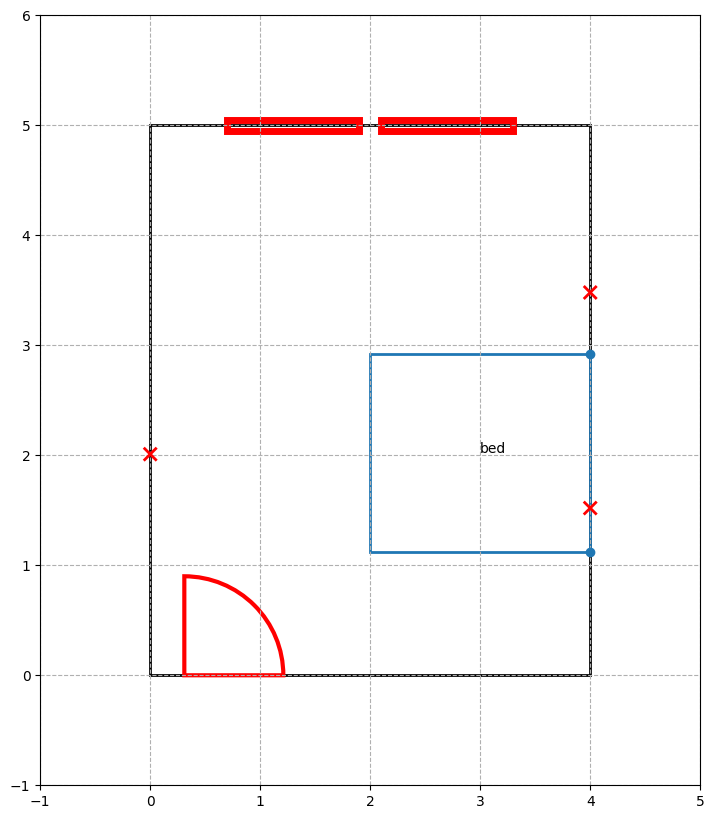

Adding in the secondary objects:  ['nightstand', 'nightstand', 'rug']
Iteration 1 , New best result found. Cost:  21.20029294874391 overlap:  0 bounds:  0
Iteration 2 , New best result found. Cost:  17.85719266325457 overlap:  0 bounds:  5.751413489865782e-10
Iteration 3 , New best result found. Cost:  4.2257869147429465 overlap:  0 bounds:  5.37642529211003e-05
Iteration 8 , New best result found. Cost:  3.793014824597991 overlap:  0 bounds:  0.07222433406652741
Iteration 19 , New best result found. Cost:  1.3881812951496575 overlap:  0 bounds:  8.22900627295478e-08


/Users/gabriellelittlefair/miniforge3/envs/MV00/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Iteration 47 , New best result found. Cost:  1.3881274128936143 overlap:  0 bounds:  4.386069640989637e-09


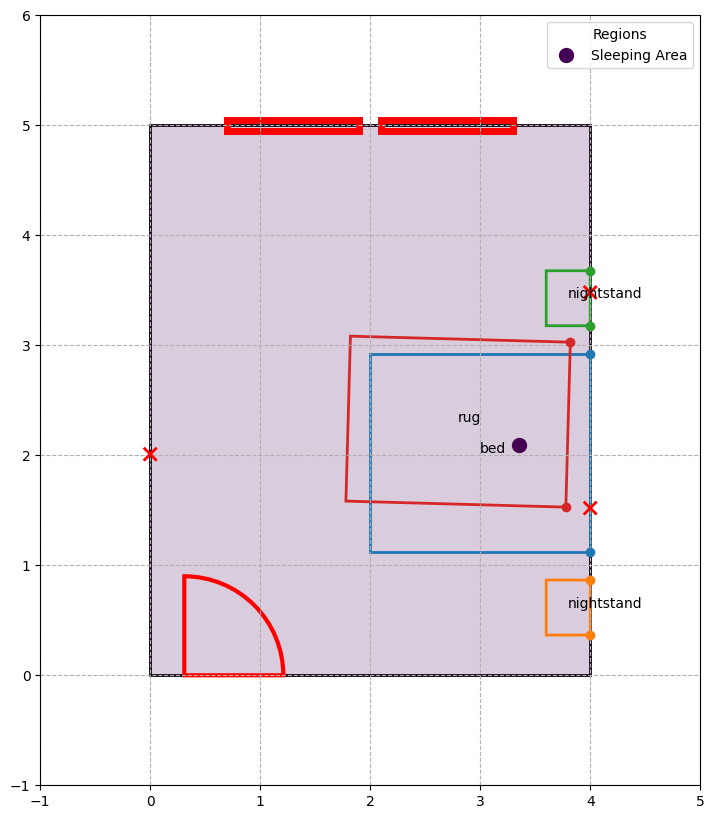

Adding in the primary object:  wardrobe
New best result found. Cost:  0.6886054973439093
New best result found. Cost:  0.5003648540053461
New best result found. Cost:  0.4998501411665781
New best result found. Cost:  0.4998474874036647
New best result found. Cost:  0.4998465754056052
New best result found. Cost:  0.4998461508905355
New best result found. Cost:  0.49984598569408323
100


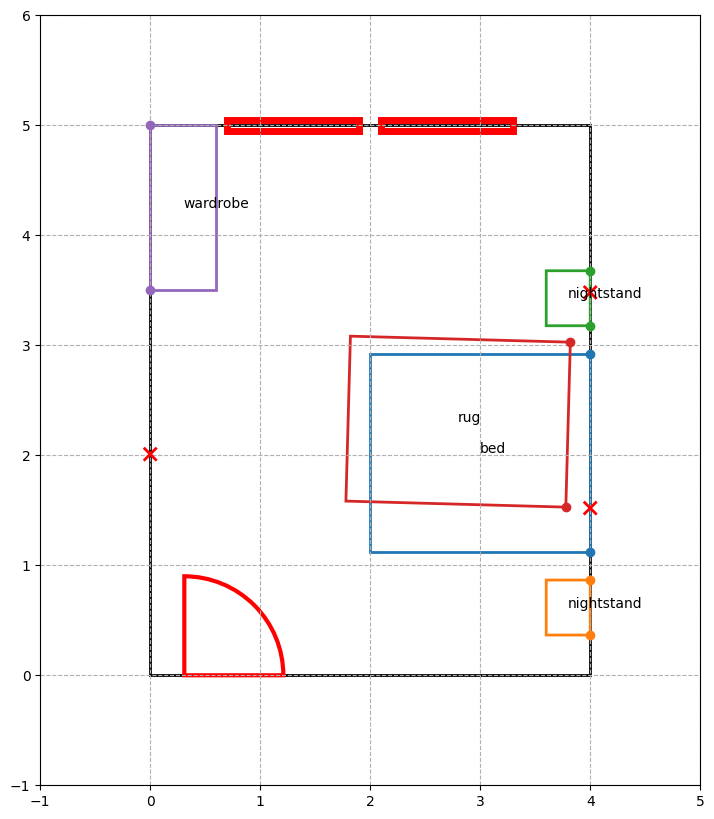

Adding in the secondary objects:  ['chest of drawers', 'laundry basket']
Iteration 1 , New best result found. Cost:  13.20789434900964 overlap:  0.12450841974915777 bounds:  0.32735308493923243
Iteration 2 , New best result found. Cost:  8.231250281994482 overlap:  0.008755007424272154 bounds:  0.05297803770099118
Iteration 3 , New best result found. Cost:  5.318771985477132 overlap:  0.01721420032031544 bounds:  0.007225131844329692
Iteration 5 , New best result found. Cost:  5.240330165001716 overlap:  0.044192827139303795 bounds:  0.0052102728806276
Iteration 8 , New best result found. Cost:  3.277050260029677 overlap:  0 bounds:  0.006095262548786513
Iteration 9 , New best result found. Cost:  3.113269070687361 overlap:  0 bounds:  6.848621570571708e-05
Iteration 19 , New best result found. Cost:  3.0961747047518346 overlap:  0 bounds:  3.227939195993048e-05
Iteration 90 , New best result found. Cost:  3.089797199657262 overlap:  0 bounds:  3.086729972683228e-05


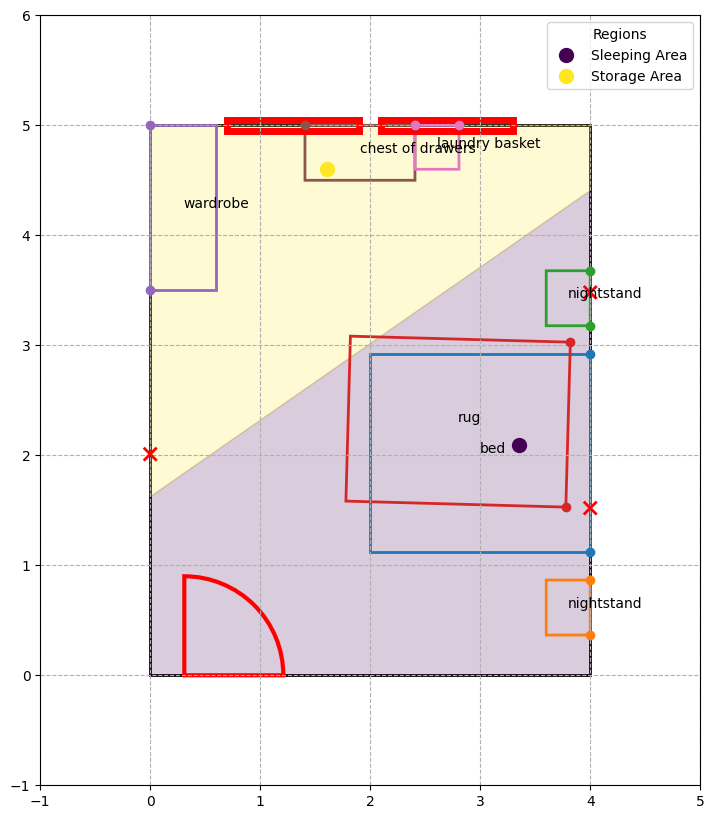

Adding in the primary object:  dressing table
New best result found. Cost:  1.3092457069416135
New best result found. Cost:  1.029381337997989
100


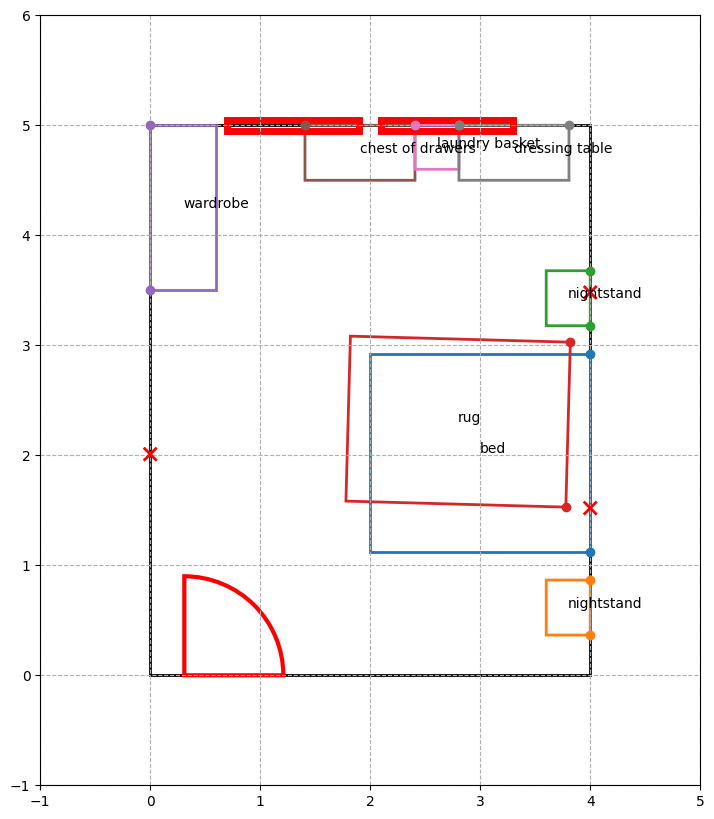

Adding in the secondary objects:  ['chair', 'full-length mirror with stand']
Iteration 6 , New best result found. Cost:  5.415343348200083 overlap:  0.00048753464714657556 bounds:  0.006777137582681617
Iteration 47 , New best result found. Cost:  5.320267791327621 overlap:  0 bounds:  0.0012492195054339954
Iteration 51 , New best result found. Cost:  4.862640840240555 overlap:  0.02021574726289022 bounds:  0.0009732980261221869
Iteration 61 , New best result found. Cost:  4.752431474044441 overlap:  0.01837502156883081 bounds:  4.600629581967998e-05


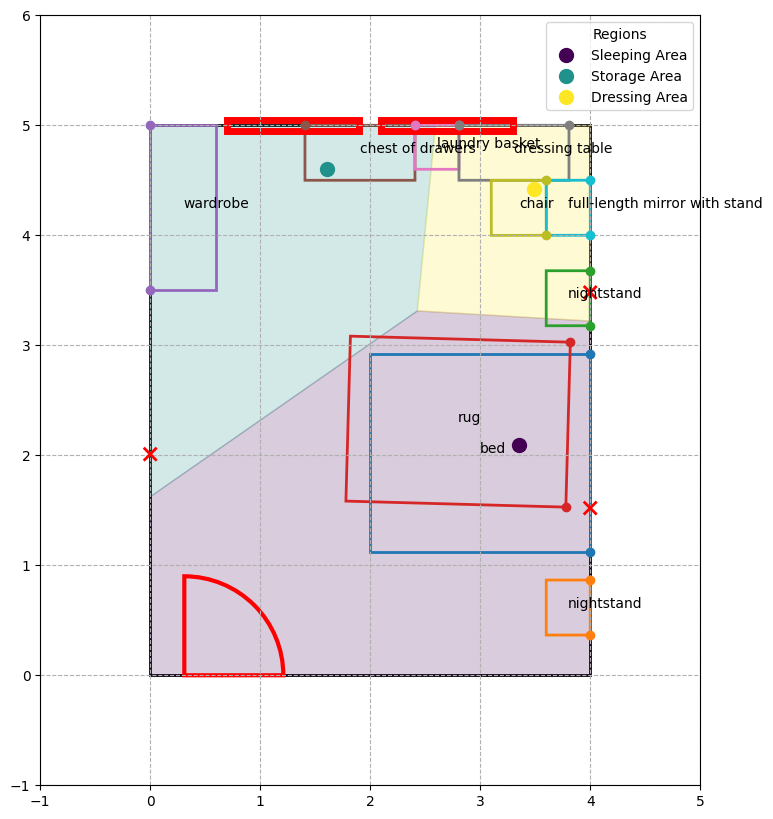

Time taken:  459.2261230945587


In [103]:
global_context = globals().copy()
local_context = {}
local_context2 = {}
exec(response1, global_context, local_context)

for region in range(num_regions):
    exec(primary_functions[region], global_context, local_context) # define the very first optimizaton function 
    ## Now want to add in the first primary object
    exec(region_setups[region] + "\n" + object_creations[2*region]) # add in the region
    print("Adding in the primary object: ", primary_objects[region])

    options = {'maxiter': 300, 'ftol': 1e-6}
    iters = 0
    min_fun = np.Inf
    room = local_context[room_name]
    func = local_context['optimize_primary_objects']
    while min_fun > 1e-2 and iters <100:
        positions = np.zeros(3)
        for i in range(len(room.moving_objects) - len(room.fm_indices)):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options) 
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
                min_fun = res.fun
                best_res = res
                print("New best result found. Cost: ", min_fun)

    print(iters)
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res.x[3*j:3*j + 3] 
    room.draw() 
    prime_index = primary_object_indices[region]

    room.regions[region].x, room.regions[region].y = room.moving_objects[prime_index].position[0], room.moving_objects[prime_index].position[1]
    prev_cost = min_fun 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    
    exec(object_creations[2*region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects

    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']

    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-10] * 3 * num, [room.width + 10, room.length + 10, np.Inf] * num)
    iters = 0
    min_fun = np.Inf
    best_res2 = None
    while (min_fun > 5e-2 and best_res2 is None and iters < 150) or (best_res2 and iters < 100):
        if iters == 149: 
            print("Iteration 150, no solution found, putting the objects outside of the room.")
            best_res2 = res
            best_res2.x = np.array([room.width + 3, room.length + 3, 0] * num)
        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.4:
                min_fun = res.fun 
                best_res2 = res
                print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
    
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = best_res2.x[3*j:3*j + 3] 

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw(draw_regions = True) 

    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]
    prev_cost = min_fun 

end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken: ", elapsed_time)

18.577350961517453


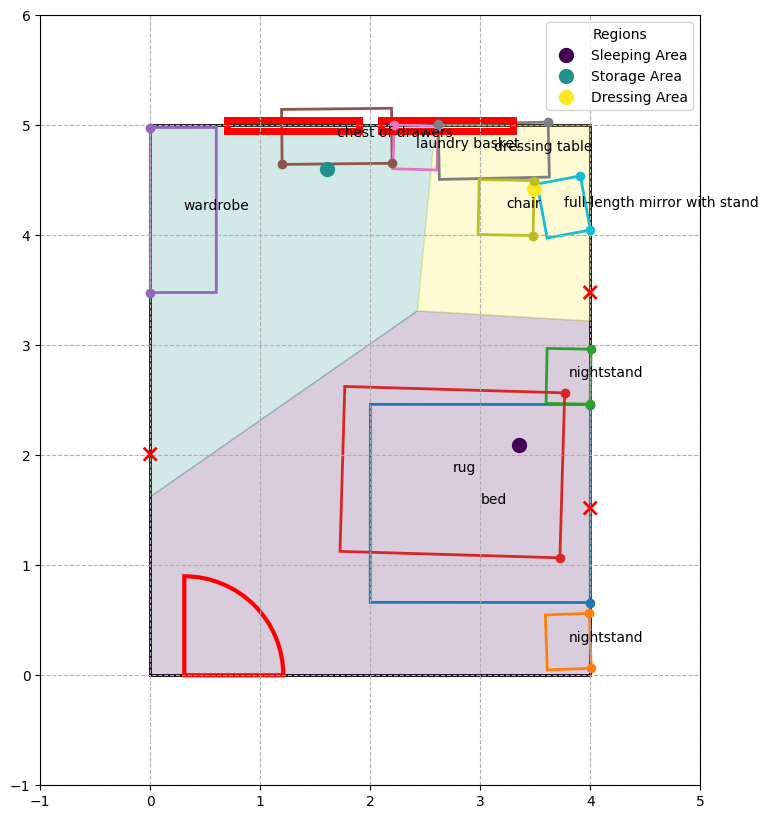

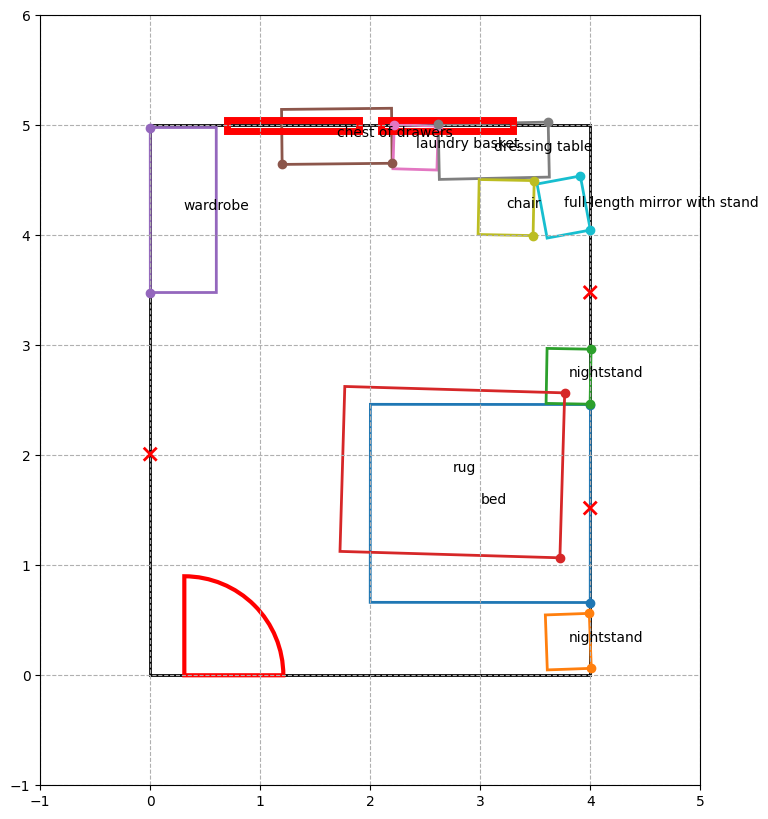

In [104]:
room.fm_indices = []
positions = np.zeros(3*len(room.moving_objects))
for i in range(len(room.moving_objects)):
    positions[3*i] = room.moving_objects[i].position[0]
    positions[3*i + 1] = room.moving_objects[i].position[1]
    positions[3*i + 2] = room.moving_objects[i].position[2]

exec(final_function, global_context, local_context2)
bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, np.Inf] * len(room.moving_objects))
func = local_context2['optimize']

res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
print(res.fun)
for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = res.x[3*i:3*i + 3]
room.draw(draw_regions = True)
room.draw()